# Georgian Digital Alphabet Recognition

### Preprocessing
add useful imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
%matplotlib inline

turns a number to a one hot array

In [2]:
def to_one_hot(values: np.ndarray, max: int) -> np.matrix:
    one_hot = np.zeros((values.size, max))
    rows = np.arange(values.size)
    one_hot[rows, values] = 1    

    return one_hot

import image data and convert images to numpy arrays

In [3]:
import matplotlib.image as im

X_arr = list[np.ndarray]()
Y_arr = list[int]()
num_chars = ord("ჰ") - ord("ა") + 1

for i in range(num_chars):
    char = chr(ord("ა") + i)

    file_path_1 = f"data/Letters/{char}"
    file_path_2 = f"data/images/{char}"

    for j, image in enumerate(os.listdir(file_path_1)):
        img_data = im.imread(f"{file_path_1}/{image}").ravel()

        X_arr.append(np.append(img_data, np.ones(10000 - len(img_data))))
        Y_arr.append(i)
    
    for j, image in enumerate(os.listdir(file_path_2)):
        img_data = im.imread(f"{file_path_2}/{image}").ravel()

        X_arr.append(np.append(img_data, np.ones(10000 - len(img_data))))
        Y_arr.append(i)

turn list of image values to numpy matrix, values to one_hot vector

In [4]:
X = np.asmatrix(X_arr)
Y = to_one_hot(np.asarray(Y_arr), num_chars)

X.shape, Y.shape

((96897, 10000), (96897, 33))

divide data to train, validation, and test

In [5]:
division_points = (int(X.shape[0] * 0.6), int(X.shape[0] * 0.8))

data = np.append(X, Y, 1)
np.random.shuffle(data)

X = data[:, 0: X.shape[1]]
Y = data[:, X.shape[1]:]

X_train = X[0: division_points[0], :]
Y_train = Y[0: division_points[0], :]

X_valid = X[division_points[0]: division_points[1], :]
Y_valid = Y[division_points[0]: division_points[1], :]

X_test = X[division_points[1]:, :]
Y_test = Y[division_points[1]:, :]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape, X_test.shape, Y_test.shape

((58138, 10000),
 (58138, 33),
 (19379, 10000),
 (19379, 33),
 (19380, 10000),
 (19380, 33))

add normalizarion to the three datas seperately

In [6]:
X_train -= X_train.mean(0)
X_valid -= X_valid.mean(0)
X_test -= X_test.mean(0)

##### Reduce dimensions using PCA for data compression reasons
find minimum dimension to reduce data to

In [7]:
min_dimension = 0

sigma = (1 / X_train.shape[0]) * X.T * X
u, s, _ = np.linalg.svd(sigma)

dimension_sum = 0
full_sum = np.sum(s)

for k in range(len(s)):
    dimension_sum += s[k]
    variance_retained = dimension_sum / full_sum

    if variance_retained > 0.99:
        min_dimension = k
        break

In [8]:
min_dimension

2344

reduce data

In [9]:
u_reduce = u[:, : min_dimension]

X_train = X_train * u_reduce
X_valid = X_valid * u_reduce
X_test = X_test * u_reduce

X_train.shape, X_valid.shape, X_test.shape

((58138, 2344), (19379, 2344), (19380, 2344))

### Build a model
build a model using tensorFlow and Keras libraries

In [35]:
from typing import Optional

def get_model(alpha: float, lambd: Optional[float] = None) -> tf.keras.Sequential:
    from tensorflow.keras.regularizers import l2

    if lambd is None:
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(min_dimension,)),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(num_chars, activation='softmax')
        ])
    
    else:
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=min_dimension),
            tf.keras.layers.Dense(256, activation='relu', activity_regularizer=l2(l=lambd)),
            tf.keras.layers.Dense(128, activation='relu', activity_regularizer=l2(l=lambd)),
            tf.keras.layers.Dense(num_chars, activation='softmax', activity_regularizer=l2(l=lambd))
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=alpha), 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )

    return model

##### draw the graph of model costs to choose the best alpha

In [34]:
alpha = 0.001

model = get_model(alpha)

history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid))
loss = history.history['loss']

Epoch 1/10
1817/1817 [==============================] - 12s 7ms/step - loss: 1.2221 - accuracy: 0.6623 - val_loss: 0.8410 - val_accuracy: 0.7572
Epoch 2/10
1817/1817 [==============================] - 13s 7ms/step - loss: 0.5316 - accuracy: 0.8395 - val_loss: 0.7492 - val_accuracy: 0.7985
Epoch 3/10
1817/1817 [==============================] - 13s 7ms/step - loss: 0.3157 - accuracy: 0.9025 - val_loss: 0.7879 - val_accuracy: 0.8042
Epoch 4/10
1817/1817 [==============================] - 14s 8ms/step - loss: 0.2197 - accuracy: 0.9315 - val_loss: 0.9070 - val_accuracy: 0.8021
Epoch 5/10
1817/1817 [==============================] - 13s 7ms/step - loss: 0.1732 - accuracy: 0.9465 - val_loss: 0.9524 - val_accuracy: 0.8113
Epoch 6/10
1817/1817 [==============================] - 13s 7ms/step - loss: 0.1343 - accuracy: 0.9596 - val_loss: 1.1088 - val_accuracy: 0.8063
Epoch 7/10
1817/1817 [==============================] - 13s 7ms/step - loss: 0.1367 - accuracy: 0.9596 - val_loss: 1.1368 - val_ac

Text(0.5, 1.0, 'Error vs. Training Epoch')

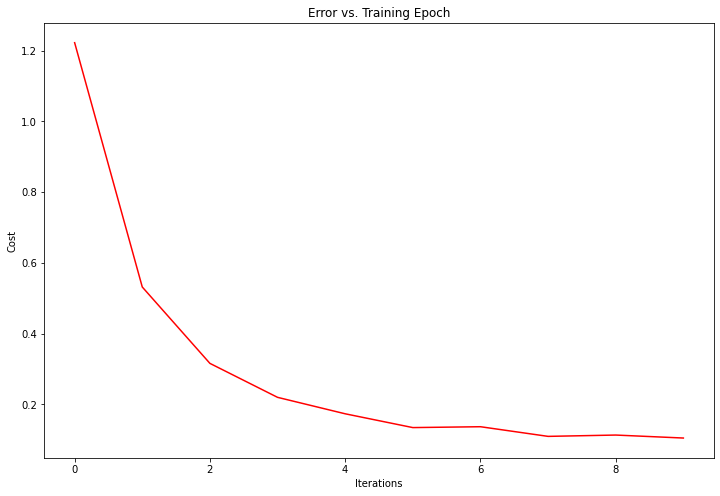

In [36]:
vfig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(len(loss)), loss, 'r')
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')
ax.set_title('Error vs. Training Epoch')

##### choose optimal lambda for the model

In [41]:
lambdas: list[float] = [0]

lambd = 0.01
while lambd < 11:
    lambdas.append(lambd)
    
    lambd *= 2

In [40]:
errors_train = np.zeros(len(lambdas))
errors_valid = np.zeros(len(lambdas))
models: list[tf.keras.Sequential] = []

for i, lambd in enumerate(lambdas):
    model = get_model(alpha, lambd)
    history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid))
    models.append(model)

    train_accuracy = history.history['accuracy'][-1]
    valid_accuracy = history.history['val_accuracy'][-1]

    errors_train[i] = 1 - train_accuracy
    errors_valid[i] = 1 - valid_accuracy

    print(f"{i + 1} / {len(lambdas)}")

Epoch 1/10
1817/1817 [==============================] - 13s 7ms/step - loss: 1.7394 - accuracy: 0.6502 - val_loss: 1.2637 - val_accuracy: 0.7458
Epoch 2/10
1817/1817 [==============================] - 14s 8ms/step - loss: 0.9333 - accuracy: 0.8279 - val_loss: 1.1244 - val_accuracy: 0.7705
Epoch 3/10
1817/1817 [==============================] - 14s 8ms/step - loss: 0.6832 - accuracy: 0.8919 - val_loss: 1.1087 - val_accuracy: 0.7715
Epoch 4/10
1817/1817 [==============================] - 14s 8ms/step - loss: 0.5708 - accuracy: 0.9212 - val_loss: 1.1584 - val_accuracy: 0.7641
Epoch 5/10
1817/1817 [==============================] - 13s 7ms/step - loss: 0.5238 - accuracy: 0.9335 - val_loss: 1.1671 - val_accuracy: 0.7641
Epoch 6/10
1817/1817 [==============================] - 13s 7ms/step - loss: 0.4890 - accuracy: 0.9430 - val_loss: 1.2151 - val_accuracy: 0.7646
Epoch 7/10
1817/1817 [==============================] - 13s 7ms/step - loss: 0.4689 - accuracy: 0.9493 - val_loss: 1.2469 - val_ac

KeyboardInterrupt: 

In [ ]:
lambd = lambdas[errors_valid.argmin()]
model = models[errors_valid.argmin()]
lambd

0

Text(0.5, 1.0, 'Error vs. Lambda Value')

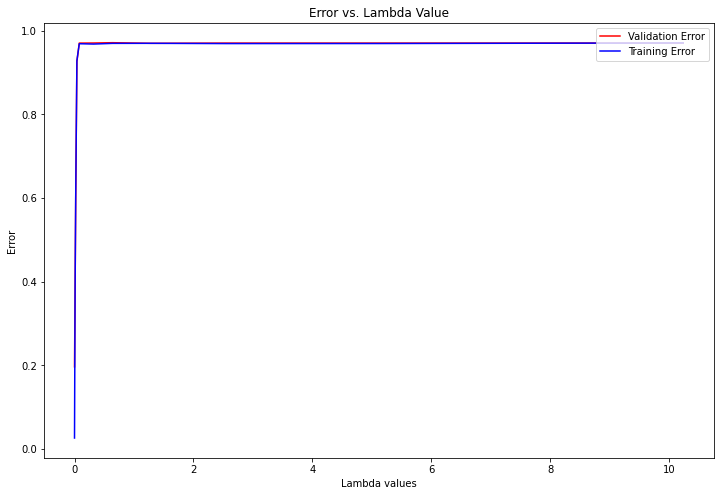

In [ ]:
vfig, ax = plt.subplots(figsize=(12,8))
ax.plot(lambdas, errors_valid, 'r', label="Validation Error")
ax.plot(lambdas, errors_train, 'b', label="Training Error")
ax.legend(loc=1)
ax.set_xlabel('Lambda values')
ax.set_ylabel('Error')
ax.set_title('Error vs. Lambda Value')

##### debug model using learning curves

In [28]:
errors_train = np.zeros(10)
errors_valid = np.zeros(10)

for i in range(10):
    X_train_div = X_train[0: int(((i + 1) * X_train.shape[0]) / 10), :]
    Y_train_div = Y_train[0: int(((i + 1) * Y_train.shape[0]) / 10), :]
    X_valid_div = X_valid[0: int(((i + 1) * X_valid.shape[0]) / 10), :]
    Y_valid_div = Y_valid[0: int(((i + 1) * Y_valid.shape[0]) / 10), :]

    model = get_model(alpha, lambd)
    history = model.fit(X_train_div, Y_train_div, epochs=10, validation_data=(X_valid_div, Y_valid_div))

    train_accuracy = history.history['accuracy'][-1]
    valid_accuracy = history.history['val_accuracy'][-1]

    errors_train[i] = 1 - train_accuracy
    errors_valid[i] = 1 - valid_accuracy

    print(f"{i + 1} / 10")    

Epoch 1/10
182/182 [==============================] - 1s 4ms/step - loss: 3.0664 - accuracy: 0.2240 - val_loss: 2.3825 - val_accuracy: 0.3934
Epoch 2/10
182/182 [==============================] - 0s 3ms/step - loss: 1.5626 - accuracy: 0.6219 - val_loss: 1.7124 - val_accuracy: 0.5385
Epoch 3/10
182/182 [==============================] - 0s 3ms/step - loss: 0.7891 - accuracy: 0.8109 - val_loss: 1.6454 - val_accuracy: 0.5591
Epoch 4/10
182/182 [==============================] - 0s 2ms/step - loss: 0.4457 - accuracy: 0.9016 - val_loss: 1.6939 - val_accuracy: 0.5643
Epoch 5/10
182/182 [==============================] - 0s 2ms/step - loss: 0.2731 - accuracy: 0.9458 - val_loss: 1.7840 - val_accuracy: 0.5643
Epoch 6/10
182/182 [==============================] - 1s 3ms/step - loss: 0.1768 - accuracy: 0.9677 - val_loss: 1.8846 - val_accuracy: 0.5710
Epoch 7/10
182/182 [==============================] - 0s 2ms/step - loss: 0.1180 - accuracy: 0.9811 - val_loss: 1.9773 - val_accuracy: 0.5689
Epoch 

Text(0.5, 1.0, 'Error vs. Data Size')

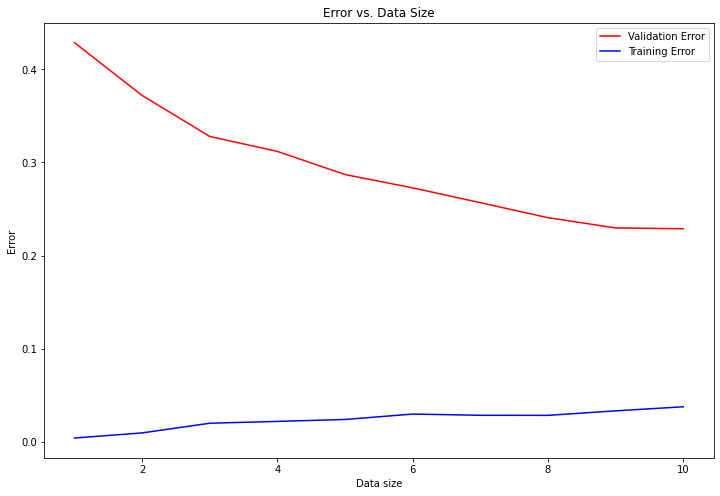

In [29]:
vfig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(10) + 1, errors_valid, 'r', label="Validation Error")
ax.plot(np.arange(10) + 1, errors_train, 'b', label="Training Error")
ax.legend(loc=1)
ax.set_xlabel('Data size')
ax.set_ylabel('Error')
ax.set_title('Error vs. Data Size')

In [ ]:
nn = model

In [ ]:
def predict(predictions: np.matrix) -> np.matrix:
    return to_one_hot(np.asarray(predictions.argmax(axis=1)).ravel(), num_chars)

In [ ]:
def get_accuracy(model: tf.keras.Sequential, X: np.matrix, Y: np.matrix) -> float:
    return (predict(model.predict(X)) == Y).all(axis=1).mean()

In [30]:
get_accuracy(nn, X_test, Y_test)

0.802218782249742

In [ ]:
get_accuracy(nn, X_train, Y_train)

0.9806838900546975